# Pokemon data set

In this chapter I will wrap everythong up that was presented in chapters 1, 2 and 3 and work with real images that are colored and labeled regarding pokemon. 

The **pokemon_project/** folder has a file called **pokemon.csv** and a folder called **images**. All the images are 120 x 120 x 3 pictures.

The csv file maps pokemon name to a type of pokemon and images folder contains the pokemon image. 

In [254]:
import pandas as pd 
import os 

pokemon_data = pd.read_csv('pokemon_project/pokemon.csv')

In [255]:
pokemon_data.head()

,Name,Type
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire


In [256]:
pokemon_data.shape

(809, 2)

In [257]:
pokemon_data.groupby('Type').size().to_frame(name='count').sort_values('count', ascending=False)

,count
Type,
Water,114
Normal,105
Grass,78
Bug,72
Fire,53
Psychic,53
Rock,46
Electric,40
Poison,34


There are 809 unique pokemon in the dataset and the most of the pokemon are the water type.

In [258]:
poke_img = os.listdir('pokemon_project/images')
poke_img[0:10]

['abomasnow.png',
 'abra.png',
 'absol.png',
 'accelgor.png',
 'aegislash-blade.png',
 'aerodactyl.png',
 'aggron.png',
 'aipom.png',
 'alakazam.png',
 'alomomola.png']

In [259]:
len(poke_img)

809

Let us first convert all images to .jpg type for ease of coding later.

In [260]:
from PIL import Image

for filename in os.listdir('pokemon_project/images'):
    if filename.endswith(".png"): 
        im = Image.open(f'pokemon_project/images/{filename}')
        im = im.convert('RGB')
        im.save(f'pokemon_project/images/{filename}'.replace('.png', '.jpg'))
    
# Creating a feature with the path to image
pokemon_data['img_path'] = [f'pokemon_project/images/{x}.jpg' for x in pokemon_data['Name']]

C:\Users\elaso\AppData\Roaming\Python\Python37\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Each pokemon has an image of it. Let us visualize some water type pokemon and random other type pokemon. 

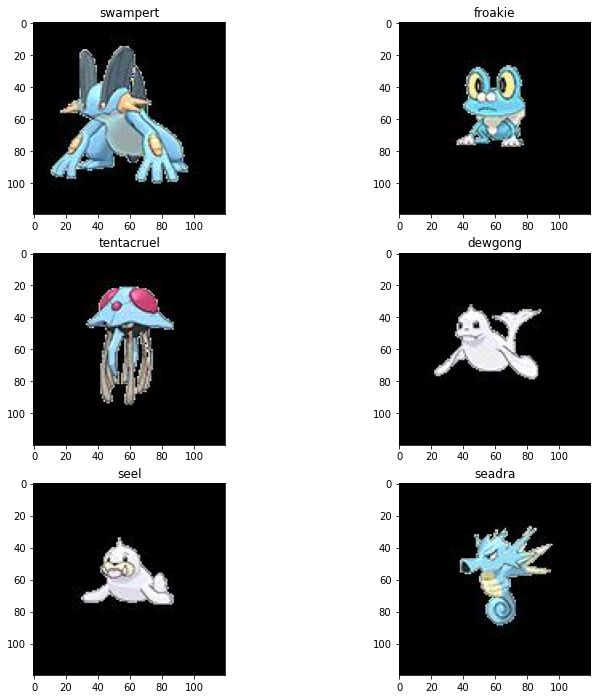

In [261]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(12, 12))

water = pokemon_data[pokemon_data['Type']=='Water'].sample(6)
water.reset_index(inplace=True)

for i, pokemon in water.iterrows():
    plt.subplot(3, 2, i + 1)
    img = mpimg.imread(pokemon['img_path'])
    plt.imshow(img)
    plt.title(pokemon['Name'])
plt.show()

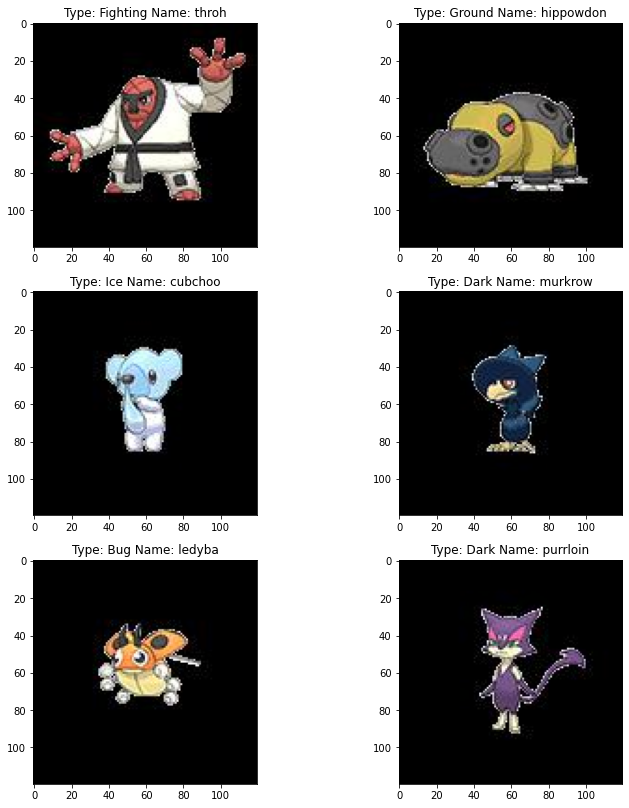

In [262]:
plt.figure(figsize=(12, 14))

not_water = pokemon_data[pokemon_data['Type']!='Water'].sample(6)
not_water.reset_index(inplace=True)

for i, pokemon in not_water.iterrows():
    plt.subplot(3, 2, i + 1)
    img = mpimg.imread(pokemon['img_path'])
    plt.imshow(img)
    plt.title(f"Type: {pokemon['Type']} Name: {pokemon['Name']}")
plt.show()

Now lets put the water type pokemon to a folder called water and all other pokemon to a folder called not_water. Both of these folders will in a directory called binary.

In [263]:
import shutil

try:
    os.mkdir('pokemon_project/binary')
    os.mkdir('pokemon_project/binary/water')
    os.mkdir('pokemon_project/binary/not_water')
except Exception as e:
    print(f'Cannot create folders {e}') 
    
for _, pokemon in pokemon_data.iterrows():
    if pokemon['Type']=='Water':
        shutil.copy(pokemon['img_path'], f"pokemon_project/binary/water/")
    else:
        shutil.copy(pokemon['img_path'], f"pokemon_project/binary/not_water/")        

# Tensorflow pipeline

I will introduce a new helper functionality from tensorflow called ImageDataGenerator. Given our folder structure /binary/water and /binary/not_water, the helper function will prepare the data for use. 

In [264]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalizing the images
train_datagen = ImageDataGenerator(rescale=1/255)

# Initiating the helper class
train_generator = train_datagen.flow_from_directory(
   "pokemon_project/binary",  # This is the source directory for training images
    target_size=(120, 120),  # All images will be resized to 120x120
    batch_size=10,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary',
    # We have saved the images in an rgba format using PIL library
    color_mode='rgb'
)

Found 809 images belonging to 2 classes.


In [265]:
model = tf.keras.models.Sequential([
        # This is the first convolution
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(120, 120, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit_generator(
        train_generator,  
        epochs=7
    )

Epoch 1/7
81/81 [==============================] - 7s 85ms/step - loss: 0.4733 - accuracy: 0.8492
Epoch 2/7
81/81 [==============================] - 7s 83ms/step - loss: 0.3875 - accuracy: 0.8591
Epoch 3/7
81/81 [==============================] - 7s 82ms/step - loss: 0.3666 - accuracy: 0.8591
Epoch 4/7
81/81 [==============================] - 7s 84ms/step - loss: 0.3176 - accuracy: 0.8714
Epoch 5/7
81/81 [==============================] - 7s 83ms/step - loss: 0.2476 - accuracy: 0.9023
Epoch 6/7
81/81 [==============================] - 7s 88ms/step - loss: 0.1819 - accuracy: 0.9333
Epoch 7/7
81/81 [==============================] - 7s 89ms/step - loss: 0.1118 - accuracy: 0.9592


# Testing the model 

Now that the model is trained let us try it out on a couple of images from the internet. 

In [272]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('pokemon_project/test_images/dolphin.png', target_size=(120, 120, 4))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Normalizing 
x = x / 255

Lets start with a dolphin:

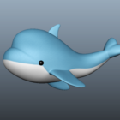

In [276]:
img

In [277]:
model.predict(x)[0]

array([0.75670695], dtype=float32)

The probability of the image of beeing a water type is 0.76 which means that we have labeld a dolphin as a water type!

Now let us test the model with something that clearly is not a water type.

In [282]:
img = image.load_img('pokemon_project/test_images/dog.jpg', target_size=(120, 120, 4))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Normalizing 
x = x / 255

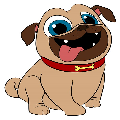

In [283]:
img

In [284]:
model.predict(x)[0]

array([0.00215706], dtype=float32)

The model says that there is a 0.002 probability that the dog in the picture is a water type. Once again, the logic fits.